# Image Segmentation of Spiral Galaxies

This notebook provides a detailed insight into the process that goes into the segmentation of spiral arms from images of spiral galaxies. This notebook accompanies the final year research project I completed for my Masters Degree in Professional Engineering (Software) at University of WA. The dataset used for this notebook is adapted from images retrieved from the 2nd public data release from the HSC data archive system, which is operated by Subaru Telescope and Astronomy Data Center at National Astronomical Observatory of Japan and classification of spiral galaxies from this dataset was achieved by [Tadaki et al.](https://arxiv.org/pdf/2006.13544.pdf) and all image content is a product of their work. You can register to access the HSC Data [here](https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/).

## [1] Install Dependencies

Here we will run the imports for packages that are used commonly throughout the notebook. Any other required packages will be imported within the code cell that they are required.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-03-22 04:00:22.465765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 04:00:25.707778: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-22 04:00:33.154556: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-22 04:00:33.154831: W tensorflow/strea

## [2] Data Pre-Processing

This section covers the functionality used to process the data prior to it being used in training the segmentation model. These functions take the images from the dataset (in the format of `.jpg` and `.tif` files) to a data format that is usable by the Tensorflow Keras API. To achieve a concise pipeline, a Keras Sequence class is used to load and vectorize the data before training the model.

### Configure Location of Data and Training Parameters

In [2]:
images_dir = 'gs://tadaki_spiral_segmentation/images'
masks_dir = 'gs://tadaki_spiral_segmentation/masks_png'
img_size = (64, 64)

val_split = 16 # % of total dataset to be used for validation
test_split = 16 # % of total dataset to be used for testing

batch_size = 16 # batch size per step
epochs = 20 # max number of epochs for training
steps_per_epoch = 500 # number of batches processed for each epoch

### Load Dataset and Split Into Subsets

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory, split_dataset

images_ds = image_dataset_from_directory(images_dir, 
                                         labels=None, 
                                         color_mode='grayscale', 
                                         shuffle=False, 
                                         image_size=img_size, 
                                         batch_size=None)

masks_ds = image_dataset_from_directory(masks_dir, 
                                        labels=None, 
                                        color_mode='grayscale', 
                                        shuffle=False, 
                                        image_size=img_size, 
                                        batch_size=None)

dataset = tf.data.Dataset.zip((images_ds, masks_ds))

train_ds, test_ds = split_dataset(dataset, 
                                 right_size=test_split/100, 
                                 shuffle=False)

train_ds, val_ds = split_dataset(train_ds, 
                                 right_size=val_split/(100-test_split), 
                                 shuffle=False)



train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

Found 100 files belonging to 1 classes.


2023-03-22 04:01:05.002156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 04:01:05.722867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 04:01:05.723194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 04:01:05.784325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 100 files belonging to 1 classes.


### Implement Data Augmentation Pipeline

Using in-built Keras preprocessing sequential layers, here we build a pipeline that can be used to augment the training images from the dataset.

In [4]:
def augment(image, mask):
    
    aug_model = keras.Sequential(
        layers = [
            layers.RandomFlip(mode="horizontal"),
            layers.RandomRotation((-0.25, 0.25), fill_mode="constant", fill_value=0),
            layers.RandomTranslation((-0.25, 0.25),(-0.25, 0.25), fill_mode="constant", fill_value=0),
            #layers.RandomZoom((-0.1, 0.05),(-0.1, 0.05)),
        ]
    )

    image_mask = tf.concat([image, mask], -1)
    image_mask = aug_model(image_mask)
    
    image = image_mask[:,:,:,0]
    mask = image_mask[:,:,:,1]
    
    image = tf.reshape(image, [-1, img_size[0], img_size[1], 1])
    mask = tf.reshape(mask, [-1, img_size[0], img_size[1], 1])
    
    return image, mask

aug_dataset = (
	train_ds
    .cache()
    .shuffle(50)
    .repeat()
    .map(lambda x, y: augment(x, y))
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Demonstrate Data is Loaded Correctly

The following plot should correctly display 4 examples from the augmented dataset of overlayed image segmentations.

2023-03-22 04:01:43.879603: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


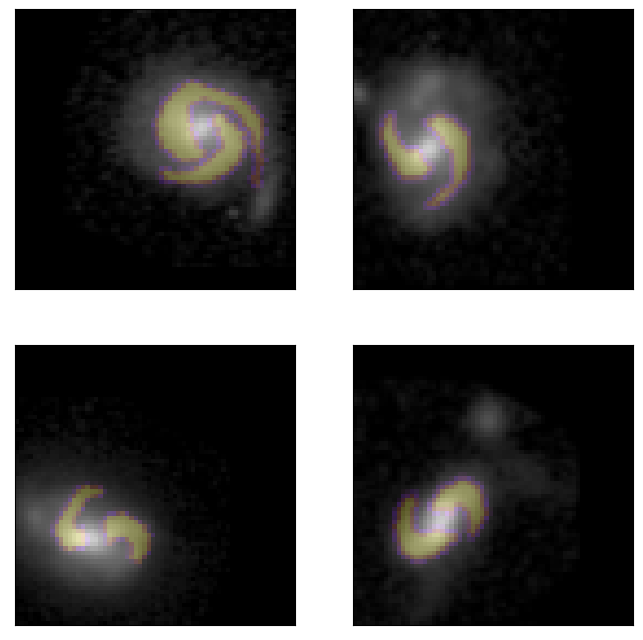

In [5]:
plt.figure(figsize=(8,8))

offset = np.random.randint(60)

for n, (image, mask) in aug_dataset.unbatch().take(4).enumerate(start=offset).as_numpy_iterator():
    
    plt.subplot(2,2,n-offset+1)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='gnuplot', alpha=0.2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## [3] Build Model

In [15]:
def get_unet():
    
    inputs = keras.Input(shape=img_size + (1,))
    
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    return keras.Model(inputs, outputs, name='U-Net')

## [4] Train Model

In [7]:
import time

model = get_unet()

checkpoint_path = time.strftime('model_checkpoints/%Y%m%d_%H_%M_%S/')
checkpoint_dir = os.path.dirname(os.path.join(checkpoint_path, 'checkpoints_data)

callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_dir, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0, restore_best_weights=True)
]

metrics = [
    keras.metrics.BinaryIoU(name='Binary IoU', threshold=0.5),
    keras.metrics.BinaryCrossentropy(name='Binary Cross-Entropy'),
    keras.metrics.BinaryAccuracy(name='Binary Accuracy', threshold=0.5),
    keras.metrics.Precision(name='Precision', thresholds=0.5),
    keras.metrics.Recall(name='Recall', thresholds=0.5)
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
model_history = model.fit(aug_dataset, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                          validation_data=val_ds, verbose=1, callbacks=callbacks)

Epoch 1/20


2023-03-22 04:01:55.458434: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


498/500 [============================>.] - ETA: 0s - loss: 0.3238 - Binary IoU: 0.4980 - Binary Cross-Entropy: 0.3238 - Binary Accuracy: 0.8906 - Precision: 0.3124 - Recall: 0.0512

INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


500/500 [==============================] - 46s 35ms/step - loss: 0.3231 - Binary IoU: 0.4980 - Binary Cross-Entropy: 0.3231 - Binary Accuracy: 0.8906 - Precision: 0.3124 - Recall: 0.0510 - val_loss: 0.1448 - val_Binary IoU: 0.4751 - val_Binary Cross-Entropy: 0.1448 - val_Binary Accuracy: 0.9501 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 0.1175 - Binary IoU: 0.4896 - Binary Cross-Entropy: 0.1175 - Binary Accuracy: 0.9006 - Precision: 0.2291 - Recall: 6.6463e-05

INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


500/500 [==============================] - 17s 33ms/step - loss: 0.1175 - Binary IoU: 0.4896 - Binary Cross-Entropy: 0.1175 - Binary Accuracy: 0.9006 - Precision: 0.2291 - Recall: 6.6463e-05 - val_loss: 0.1419 - val_Binary IoU: 0.4751 - val_Binary Cross-Entropy: 0.1419 - val_Binary Accuracy: 0.9501 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/20
499/500 [============================>.] - ETA: 0s - loss: 0.1114 - Binary IoU: 0.4896 - Binary Cross-Entropy: 0.1114 - Binary Accuracy: 0.9007 - Precision: 0.1533 - Recall: 8.3179e-06

INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


500/500 [==============================] - 18s 36ms/step - loss: 0.1114 - Binary IoU: 0.4896 - Binary Cross-Entropy: 0.1114 - Binary Accuracy: 0.9007 - Precision: 0.1533 - Recall: 8.3127e-06 - val_loss: 0.1294 - val_Binary IoU: 0.4750 - val_Binary Cross-Entropy: 0.1294 - val_Binary Accuracy: 0.9501 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/20
498/500 [============================>.] - ETA: 0s - loss: 0.1076 - Binary IoU: 0.4896 - Binary Cross-Entropy: 0.1076 - Binary Accuracy: 0.9006 - Precision: 0.1728 - Recall: 5.0737e-06

INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


500/500 [==============================] - 17s 33ms/step - loss: 0.1075 - Binary IoU: 0.4896 - Binary Cross-Entropy: 0.1075 - Binary Accuracy: 0.9007 - Precision: 0.1728 - Recall: 5.0605e-06 - val_loss: 0.1134 - val_Binary IoU: 0.4751 - val_Binary Cross-Entropy: 0.1134 - val_Binary Accuracy: 0.9501 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 5/20
499/500 [============================>.] - ETA: 0s - loss: 0.1038 - Binary IoU: 0.4896 - Binary Cross-Entropy: 0.1038 - Binary Accuracy: 0.9007 - Precision: 0.1882 - Recall: 5.7868e-06

INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


500/500 [==============================] - 17s 33ms/step - loss: 0.1038 - Binary IoU: 0.4896 - Binary Cross-Entropy: 0.1038 - Binary Accuracy: 0.9007 - Precision: 0.1882 - Recall: 5.7832e-06 - val_loss: 0.1045 - val_Binary IoU: 0.4751 - val_Binary Cross-Entropy: 0.1045 - val_Binary Accuracy: 0.9501 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.1013 - Binary IoU: 0.5460 - Binary Cross-Entropy: 0.1013 - Binary Accuracy: 0.9009 - Precision: 0.7686 - Recall: 0.1344 - val_loss: 0.1110 - val_Binary IoU: 0.6480 - val_Binary Cross-Entropy: 0.1110 - val_Binary Accuracy: 0.9334 - val_Precision: 0.4104 - val_Recall: 0.7685
Epoch 7/20
499/500 [============================>.] - ETA: 0s - loss: 0.0977 - Binary IoU: 0.5882 - Binary Cross-Entropy: 0.0977 - Binary Accuracy: 0.9028 - Precision: 0.7851 - Recall: 0.4445

INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


500/500 [==============================] - 20s 40ms/step - loss: 0.0978 - Binary IoU: 0.5883 - Binary Cross-Entropy: 0.0978 - Binary Accuracy: 0.9028 - Precision: 0.7852 - Recall: 0.4444 - val_loss: 0.0965 - val_Binary IoU: 0.6652 - val_Binary Cross-Entropy: 0.0965 - val_Binary Accuracy: 0.9496 - val_Precision: 0.4960 - val_Recall: 0.6257
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.0939 - Binary IoU: 0.6056 - Binary Cross-Entropy: 0.0939 - Binary Accuracy: 0.9065 - Precision: 0.8300 - Recall: 0.4240 - val_loss: 0.1007 - val_Binary IoU: 0.6800 - val_Binary Cross-Entropy: 0.1007 - val_Binary Accuracy: 0.9484 - val_Precision: 0.4888 - val_Recall: 0.7284
Epoch 9/20
498/500 [============================>.] - ETA: 0s - loss: 0.0883 - Binary IoU: 0.6201 - Binary Cross-Entropy: 0.0883 - Binary Accuracy: 0.9097 - Precision: 0.8671 - Recall: 0.4526

INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


500/500 [==============================] - 18s 36ms/step - loss: 0.0882 - Binary IoU: 0.6202 - Binary Cross-Entropy: 0.0882 - Binary Accuracy: 0.9097 - Precision: 0.8672 - Recall: 0.4526 - val_loss: 0.0890 - val_Binary IoU: 0.6789 - val_Binary Cross-Entropy: 0.0890 - val_Binary Accuracy: 0.9559 - val_Precision: 0.5544 - val_Recall: 0.5966
Epoch 10/20
500/500 [==============================] - 9s 18ms/step - loss: 0.0826 - Binary IoU: 0.6299 - Binary Cross-Entropy: 0.0826 - Binary Accuracy: 0.9119 - Precision: 0.8912 - Recall: 0.4744 - val_loss: 0.1022 - val_Binary IoU: 0.6667 - val_Binary Cross-Entropy: 0.1022 - val_Binary Accuracy: 0.9488 - val_Precision: 0.4898 - val_Recall: 0.6468
Epoch 11/20
498/500 [============================>.] - ETA: 0s - loss: 0.0777 - Binary IoU: 0.6402 - Binary Cross-Entropy: 0.0777 - Binary Accuracy: 0.9137 - Precision: 0.9152 - Recall: 0.4757

INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


500/500 [==============================] - 19s 38ms/step - loss: 0.0776 - Binary IoU: 0.6402 - Binary Cross-Entropy: 0.0776 - Binary Accuracy: 0.9138 - Precision: 0.9152 - Recall: 0.4757 - val_loss: 0.0888 - val_Binary IoU: 0.6926 - val_Binary Cross-Entropy: 0.0888 - val_Binary Accuracy: 0.9590 - val_Precision: 0.5852 - val_Recall: 0.6135
Epoch 12/20
500/500 [==============================] - 9s 18ms/step - loss: 0.0738 - Binary IoU: 0.6485 - Binary Cross-Entropy: 0.0738 - Binary Accuracy: 0.9151 - Precision: 0.9318 - Recall: 0.4744 - val_loss: 0.0984 - val_Binary IoU: 0.6542 - val_Binary Cross-Entropy: 0.0984 - val_Binary Accuracy: 0.9555 - val_Precision: 0.5627 - val_Recall: 0.4884
Epoch 13/20
498/500 [============================>.] - ETA: 0s - loss: 0.0687 - Binary IoU: 0.6594 - Binary Cross-Entropy: 0.0687 - Binary Accuracy: 0.9166 - Precision: 0.9523 - Recall: 0.4743

INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


INFO:tensorflow:Assets written to: galaxy_segmentation/20230322/assets


500/500 [==============================] - 16s 33ms/step - loss: 0.0687 - Binary IoU: 0.6594 - Binary Cross-Entropy: 0.0687 - Binary Accuracy: 0.9166 - Precision: 0.9523 - Recall: 0.4742 - val_loss: 0.0838 - val_Binary IoU: 0.6921 - val_Binary Cross-Entropy: 0.0838 - val_Binary Accuracy: 0.9606 - val_Precision: 0.6100 - val_Recall: 0.5832
Epoch 14/20
500/500 [==============================] - 9s 18ms/step - loss: 0.0653 - Binary IoU: 0.6646 - Binary Cross-Entropy: 0.0653 - Binary Accuracy: 0.9175 - Precision: 0.9618 - Recall: 0.4814 - val_loss: 0.0863 - val_Binary IoU: 0.6881 - val_Binary Cross-Entropy: 0.0863 - val_Binary Accuracy: 0.9622 - val_Precision: 0.6457 - val_Recall: 0.5373
Epoch 15/20
500/500 [==============================] - 9s 17ms/step - loss: 0.0618 - Binary IoU: 0.6693 - Binary Cross-Entropy: 0.0618 - Binary Accuracy: 0.9184 - Precision: 0.9710 - Recall: 0.4870 - val_loss: 0.1037 - val_Binary IoU: 0.6584 - val_Binary Cross-Entropy: 0.1037 - val_Binary Accuracy: 0.9607 

## [5] Test Model and Assess Performance

1/1 [==============================] - 0s 13ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'galaxy_segmentation/20230322/04_01_46_checkpoint.h5/analysis'

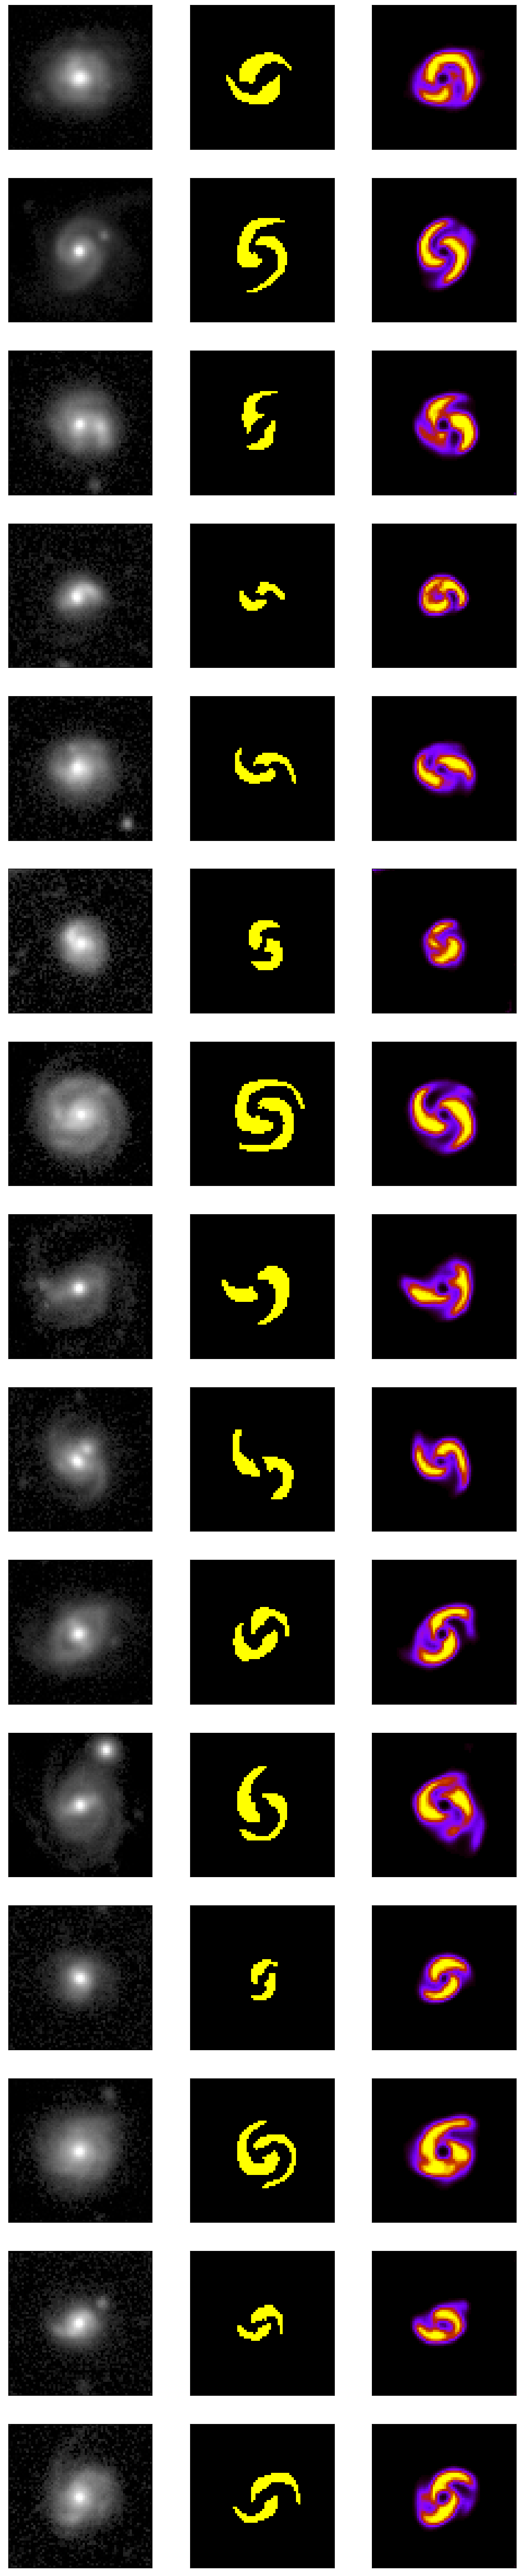

In [16]:
test_preds = model.predict(test_ds)

plt.figure(figsize=(12,60))

for n, (gt_img, gt_mask) in enumerate(test_ds.unbatch().take(15)):
    
    plt.subplot(15,3,3*n+1)
    plt.imshow(gt_img, cmap='gray', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(15,3,3*n+2)
    plt.imshow(gt_mask, cmap='gnuplot', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(15,3,3*n+3)
    plt.imshow(test_preds[n], cmap='gnuplot', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
os.mkdir(os.path.join(checkpoint_path, 'analysis'))
plt.savefig(os.path.join(checkpoint_path, 'analysis', 'test_predictions.png'))
plt.show()


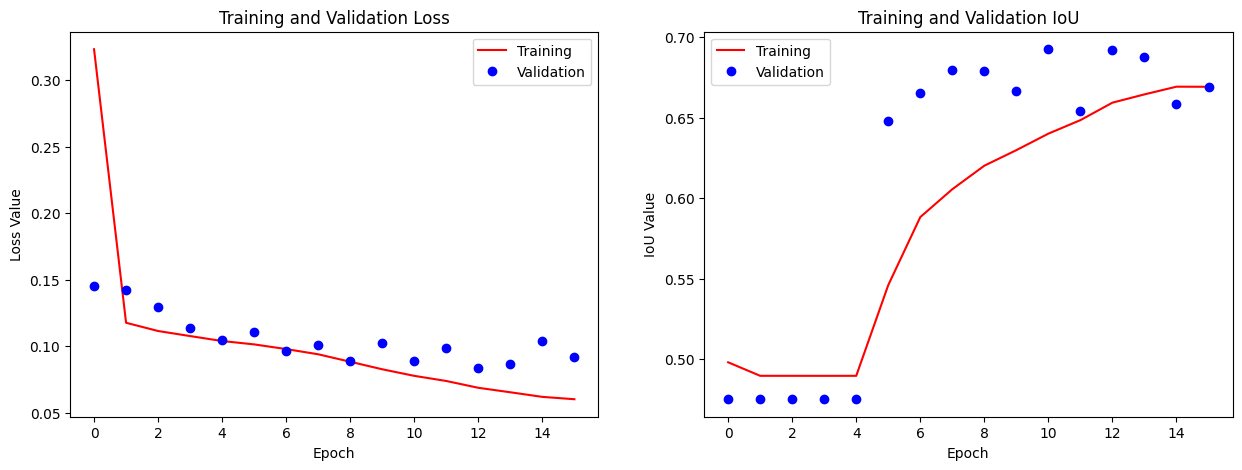

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

epochs = range(len(model_history.history['loss']))
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

ax[0].plot(epochs, loss, 'r', label='Training')
ax[0].plot(epochs, val_loss, 'bo', label='Validation')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss Value')
ax[0].legend()

iou = model_history.history['Binary IoU']
val_iou = model_history.history['val_Binary IoU']

ax[1].plot(epochs, iou, 'r', label='Training')
ax[1].plot(epochs, val_iou, 'bo', label='Validation')
ax[1].set_title('Training and Validation IoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('IoU Value')
ax[1].legend()
plt.show()